In [115]:
import sys
import numpy as np
from pathlib import Path
parent_dir = Path.cwd().parent
sys.path.append(str(parent_dir))
from instruments import *
from physical_models import *
from matplotlib.ticker import MultipleLocator

In [118]:
def plot_sys_dict_vs_wavelength(component, parameter, json_dir, save_path=None, title=None, axtitle=None):
    """
    Plots a parameter in the JSON system dictionaries vs wavelength.
    Only works if all JSON dictionaries are in a directory labeled
    by bin. Sets parameters phi, delta_theta, and theta to degrees.
    Returns an array of the parameters to allow for custom plotting.
    This plot is similar to the one in van Holstein 2020.
    
    Parameters
    ----------
    component : str
        The name of the component (e.g., 'image_rotator', 'hwp', etc.).
    parameter : str
        The key of the parameter in the system dictionary.
    json_dir : str or Path
        The directory containing the JSON system dictionaries for all 22 bins.
        Make sure the directory only contains these 22 JSON files.
    save_path : str or Path, optional
        If specified, saves the plot to this path. Otherwise, displays the plot.
    title : str, optional
        Title for the plot. If not provided, a default title is used.
    axtitle : str, optional
        Title for the y-axis. If not provided, a default title is used.
    
    Returns
    -------
    parameters : np.ndarray
        An array of the parameter values extracted from the JSON files.
        To plot, plot against the default CHARIS wavelength bins (can
        be found in instruments.py).
    """

    # Check filepaths

    json_dir = Path(json_dir)
    if not json_dir.is_dir():
        raise ValueError(f"{json_dir} is not a valid directory.")
    if save_path is not None:
        save_path = Path(save_path)

    # Load JSON files

    json_files = sorted(json_dir.glob("*.json"))

    # Check for correct file amount

    if len(json_files) != 22:
        raise ValueError(f"Expected 22 JSON files, found {len(json_files)}.")
    
    # Check for bins
 
    for f in json_files:
     try:
        match = re.search(r'bin(\d+)', f.name)
        if not match:
            raise ValueError(f"File {f.name} does not match expected naming convention.")
     except Exception as e:
        raise ValueError(f"Error processing file {f.name}: {e}")
     
     # Sort Jsons

    sorted_files = sorted(json_files, key=lambda f: int(re.search(r'bin(\d+)', f.name).group(1)))

    # Extract parameters

    parameters = []

    for f in sorted_files:
        with open(f, 'r') as file:
            data = json.load(file)
            if component not in data:
                raise ValueError(f"Component '{component}' not found in {f.name}.")
            if parameter not in data[component]:
                raise ValueError(f"Parameter '{parameter}' not found in component '{component}' in {f.name}.")
            # Set relevant components to degrees
            if parameter == 'theta' or parameter == 'delta_theta' or parameter == 'phi':
                data[component][parameter] = np.degrees(data[component][parameter])
            
            parameters.append(data[component][parameter])

    # Convert to numpy array for plotting

    parameters = np.array(parameters)

    # Plot vs wavelength bins

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.scatter(wavelength_bins, parameters, marker='x')
    ax.set_xlabel('Wavelength (nm)')
    ax.xaxis.set_major_locator(MultipleLocator(100))
    if axtitle is not None:
        ax.set_ylabel(axtitle)
    else:
        ax.set_ylabel(parameter)
    if title is None:
        ax.set_title(f'{component}: {parameter} vs wavelength')
    else:
        ax.set_title(title)
    ax.grid(True)
    if save_path is not None:
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")
    plt.show()
    return parameters
    
   

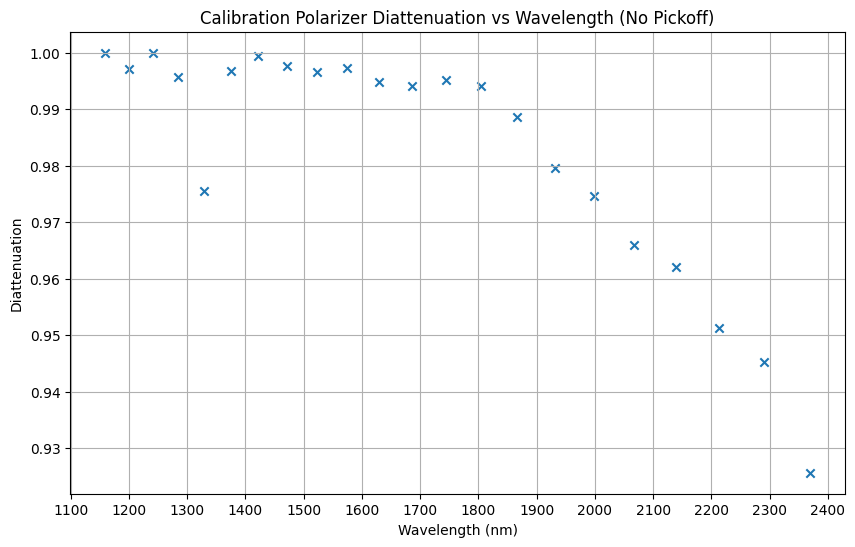

array([1.        , 0.99709503, 0.99999999, 0.99571254, 0.97556147,
       0.99682237, 0.9994478 , 0.99770519, 0.99652068, 0.99725513,
       0.99484787, 0.9941476 , 0.9951696 , 0.99416095, 0.98856916,
       0.97961264, 0.97457091, 0.96601583, 0.9620139 , 0.95121322,
       0.94526412, 0.92568841])

In [119]:
json_dir = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/system_dicts_no_pickoff_cal')
plot_path = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/plots/lpdiattenuation_vs_wavelength_no_pick.png')
plot_sys_dict_vs_wavelength('lp', 'epsilon',json_dir, title= 'Calibration Polarizer Diattenuation vs Wavelength (No Pickoff)', axtitle='Diattenuation')

In [98]:
def plot_polarimetric_efficiency(json_dir, bins, save_path=None, title=None):
    """
    Plots the polarimetric efficiency from the system dictionaries vs derotator angle.
    Only works if all JSON dictionaries are in a directory labeled
    by bin. Returns an array of the polarimetric efficiency values.
    This plot is similar to the one in van Holstein 2020. Also plots
    where measured derotator angles would be with an 'x' marker.
    
    Parameters
    ----------
    json_dir : str or Path
        The directory containing the JSON system dictionaries for all 22 bins.
        Make sure the directory only contains these 22 JSON files.
    bins : np.ndarray
        An array of wavelength bins to simultaneously plot.
    save_path : str or Path, optional
        If specified, saves the plot to this path. 
    title : str, optional
        Title for the plot. If not provided, a default title is used.

    Returns
    -------
    polarimetric_efficiency : np.ndarray
        A 2 dimensional array of the polarimetric efficiency values extracted from the JSON files
        where the first dimension corresponds to the wavelength bins and the second dimension represents the derotator angles.
    
    """
    # Check filepaths

    json_dir = Path(json_dir)
    if not json_dir.is_dir():
        raise ValueError(f"{json_dir} is not a valid directory.")
    if save_path is not None:
        save_path = Path(save_path)

    # Load JSON files

    json_files = sorted(json_dir.glob("*.json"))

    # Check for correct file amount

    if len(json_files) != 22:
        raise ValueError(f"Expected 22 JSON files, found {len(json_files)}.")
    
    # Check for bins
 
    for f in json_files:
     try:
        match = re.search(r'bin(\d+)', f.name)
        if not match:
            raise ValueError(f"File {f.name} does not match expected naming convention.")
     except Exception as e:
        raise ValueError(f"Error processing file {f.name}: {e}")
     
     # Sort Jsons

    sorted_files = sorted(json_files, key=lambda f: int(re.search(r'bin(\d+)', f.name).group(1)))

    # Get derotator angles

    derotator_angles_measured = np.array([45, 57.5,70,82.5,95,107.5,120,132.5])
    derotator_angles = np.linspace(0,180,361)

    # Get polarimetric efficiencies


    output = []
    for wavelength_bin in bins:
        # Create efficiency array
        efficiencies = []
        # Extract the Mueller matrix for each derotator angle
        for derotator_angle in derotator_angles:
            # Define system dictionary components for the current wavelength bin and derotator angle
            file = sorted_files[wavelength_bin]
            data = json.load(open(file, 'r'))
           # Parse the dictionary into usable values
            values, keywords = parse_configuration(data)

            # Generate system Mueller matrix without Wollaston prism 

            sys_dict = {
            "components" : {
              #   "wollaston" : {
              #   "type" : "wollaston_prism_function",
              #  "properties" : {"beam": "o"},
              #  "tag": "internal",
              #  },
                "image_rotator" : {
                    "type" : "general_retarder_function",
                    "properties" : {"phi": 0, "theta": derotator_angle, "delta_theta": 0},
                    "tag": "internal",
                },
                "hwp" : {
                    "type" : "general_retarder_function",
                    "properties" : {"phi":0, "theta": 0, "delta_theta": 0},
                    "tag": "internal",
                },
                "lp" : {
                    "type": "general_linear_polarizer_function_with_theta",
                    "properties": {"delta_theta": 0},
                    "tag": "internal",
                }}
            }

            # generate Mueller matrix object

            system_mm = generate_system_mueller_matrix(sys_dict)

            # Update the Mueller matrix with the model

            updated_system_mm = update_system_mm(values, keywords, system_mm)

            # Calculate the polarimetric efficiency

            M_10 = updated_system_mm.evaluate()[1,0]
            M_20 = updated_system_mm.evaluate()[2,0]
            M_00 = updated_system_mm.evaluate()[0,0]
            efficiency = np.sqrt(M_10**2 + M_20**2) / M_00
            efficiencies.append(efficiency)
        output.append(efficiencies)

    pol_efficiencies = np.array(output)

    # Grab measured angles from pol efficiencies

    measured_indices = []
    for idx,angle in enumerate(derotator_angles):
        if angle in derotator_angles_measured:
            measured_indices.append(idx)
    pol_efficiencies_measured = pol_efficiencies[:, measured_indices]

    # Plot vs derotator angle

    fig, ax = plt.subplots(figsize=(10, 6))
    for i, wavelength_bin in enumerate(bins):
        ax.plot(derotator_angles, pol_efficiencies[i], label=f"{int(wavelength_bins[wavelength_bin])} nm")
        ax.scatter(derotator_angles_measured, pol_efficiencies_measured[i], marker='x')
    ax.scatter([], [], marker='x', color='black', label='Angles Used in Data')
    ax.set_xlabel('Derotator Angle (degrees)')
    ax.set_ylabel('Polarimetric Efficiency')
    from matplotlib.ticker import MultipleLocator
    ax.xaxis.set_major_locator(MultipleLocator(15))
    ax.yaxis.set_major_locator(MultipleLocator(0.1))
    if title is None:
        ax.set_title('Polarimetric Efficiency vs Derotator Angle')
    else:
        ax.set_title(title)
    ax.grid(True)
    ax.legend()
    if save_path is not None:
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")
    plt.show()
    return pol_efficiencies





          
                

            
                    



        

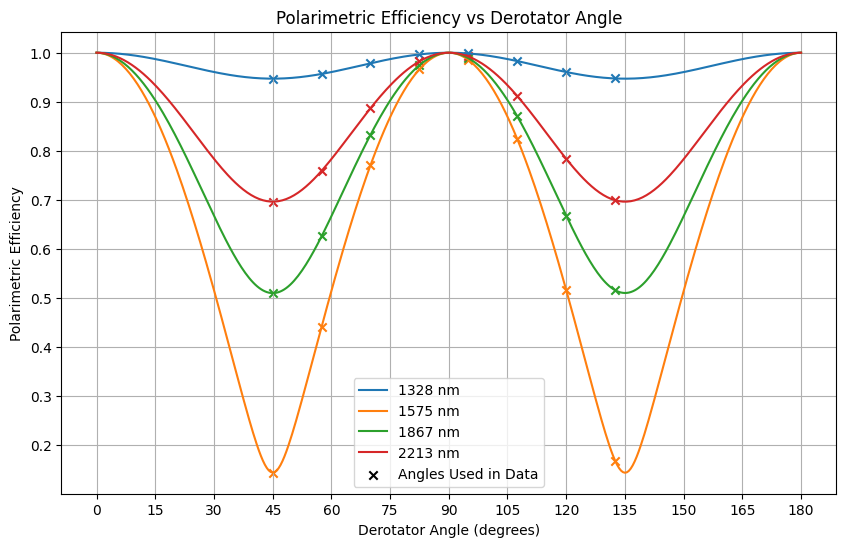

array([[0.99999989, 0.99998687, 0.99994251, ..., 0.99993188, 0.99998155,
        0.99999989],
       [0.99999913, 0.99987279, 0.99944822, ..., 0.99935707, 0.99982721,
        0.99999913],
       [0.99999944, 0.99990271, 0.99958075, ..., 0.99951709, 0.99987087,
        0.99999944],
       [0.99999953, 0.99993327, 0.99971022, ..., 0.9996616 , 0.99990895,
        0.99999953]])

In [124]:
bins = [4,9,14,19]
json_dir = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/naive_fitting/system_dicts_no_pickoff')
plot_polarimetric_efficiency(json_dir,bins)


In [53]:
json_dir = Path('/Users/thomasmcintosh/Desktop/CHARIS-REU/Fitting/system_dicts_no_pickoff')
json_files = sorted(json_dir.glob("*.json"))
sorted_files = sorted(json_files, key=lambda f: int(re.search(r'bin(\d+)', f.name).group(1)))
file = sorted_files[4]
data = json.load(open(file, 'r'))
# Parse the dictionary into usable values
values, keywords = parse_configuration(data)
sys_dict = {
"components" : {
# "wollaston" : {
# "type" : "wollaston_prism_function",
# "properties" : {"beam": "o"},
# "tag": "internal",
# },
"image_rotator" : {
"type" : "general_retarder_function",
"properties" : {"phi": 4.3, "theta": 22.5, "delta_theta": 0},
"tag": "internal",
},
"hwp" : {
"type" : "general_retarder_function",
"properties" : {"phi":3.02, "theta": 12.5, "delta_theta": 0},
"tag": "internal",
},
"lp" : {
"type": "general_linear_polarizer_function_with_theta",
"properties": {"delta_theta": 0},
"tag": "internal",
}}
}

# generate Mueller matrix object

system_mm = generate_system_mueller_matrix(sys_dict)
# update_system_mm(values, keywords, system_mm)
print(system_mm.evaluate())


[[0.5        0.5        0.         0.        ]
 [0.38036956 0.38036956 0.         0.        ]
 [0.32329183 0.32329183 0.         0.        ]
 [0.02830877 0.02830877 0.         0.        ]]
